# Chapter 11 - Portfolio theory - efficient portfolios
---

In [1]:
# Preamble
import pandas as pd
import numpy as np
import os # To set our working folder
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen as uReq
import urllib.error as uErr
import re
import tenacity
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as mticker
import seaborn as sns
import yfinance as yf  # This gets us prices from Yahoo finance. See https://pypi.org/project/yfinance/
from linearmodels.panel import PanelOLS
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tabulate import tabulate


if os.name=='nt':
    import xlwings as xw


@tenacity.retry(wait=tenacity.wait_exponential(multiplier=1, min=4, max=64), stop=tenacity.stop_after_attempt(5))
def get_that_page(url):
    try:
        req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
        uClient = uReq(req)
        print('Success')
    except Exception:
        print('Trying again.')
    return uClient


def do_table(url):
    uClient = get_that_page(url)
    soup = BeautifulSoup(uClient, 'lxml')
    table = soup.find('table', class_='instruments-table')
    table_headers =[]
    for tx in soup.find_all('th'):
        table_headers.append(tx.get('id'))

    filler = ['unknown', 'pct']
    data = []
    rows = table.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        #print(cols)
        if len(cols)>0:
            data.append(cols)
    df = pd.DataFrame(data, columns=[x if x!=None else filler.pop() for x in table_headers])
    lyst = ['price', 'volume', 'value', 'outstanding_capitalisation', 'market_capitalisation', 'pct', 'trade_count']
    df[lyst] = df[lyst].replace({'\$': '', ',': ''}, regex=True).apply(pd.to_numeric,  errors='coerce')
    df['green_bond']= df['green_bond'].map({'false': 0, 'true': 1})
    df = df[~df['company'].str.contains('Smartshares')]
    df['code'] = df['code']+".NZ"
    nzx = df['code'].to_list()

    return(df[df['market_capitalisation']>0], nzx)


def set_xmargin(ax, left=0.0, right=0.3):
    ax.set_xmargin(0)
    ax.autoscale_view()
    lim = ax.get_xlim()
    delta = np.diff(lim)
    left =  lim[0] - delta*left
    right = lim[1] + delta*right
    ax.set_xlim(left,right)


def nice_print(df, k=1, name=""):
    if isinstance(df, pd.DataFrame):
        print(tabulate(k*df, tablefmt="fancy_grid", floatfmt=".4f", headers="keys"))
    elif isinstance(df, pd.Series):
        df.name= name
        df=df.to_frame()
        print(tabulate(k*df, tablefmt="fancy_grid", floatfmt=".4f", headers="keys"))


dfm, nzx  = do_table('https://www.nzx.com/markets/NZSX')

Success


In [2]:
def returns(nzx, start, end):
    df_close = yf.download(nzx, start, end, progress=True, interval="1mo")['Adj Close']
    df_close.dropna(how = 'all', inplace=True, axis = 1)
    df_close.sort_index(inplace=True)
    df_close.index = pd.to_datetime(df_close.index, format ='%Y-%m-%d')
    df_close.columns = [re.sub(r'.NZ$|\^', "", x) for x in list(df_close)]
    return list(df_close), df_close.resample('M').last()

nzx_set, df_close = returns(nzx+['^NZ50'], '2017-03-31', '2022-04-30')
#nzx_set, df_close = returns(nzx+['^NZ50'], '2015-01-01', '2019-12-30')

[*********************100%***********************]  152 of 152 completed

9 Failed downloads:
- KFLWG.NZ: No data found, symbol may be delisted
- PLP.NZ: No data found for this date range, symbol may be delisted
- FCT.NZ: No data found for this date range, symbol may be delisted
- CO2.NZ: No data found for this date range, symbol may be delisted
- BIT.NZ: No data found for this date range, symbol may be delisted
- BIF.NZ: No data found for this date range, symbol may be delisted
- MLNWE.NZ: No data found, symbol may be delisted
- AKL.NZ: No data found, symbol may be delisted
- NTLOB.NZ: No data found, symbol may be delisted


In [3]:
df_close.shape

(62, 143)

### Building a portfolio of multiple stocks

In [4]:
stocks_list = ["ANZ", 'WHS', 'RYM', 'THL', "FPH", "EBO", 'ATM']
#stocks_list = ["FPH", "MEL", "AIA", "SPK", "MCY", "MFT", "EBO", "CEN", "IFT", "FBU", "RYM", "POT", "VCT", "ATM", "CNU", "GMT", "GNE", "SUM", "PCT", "TPW"]
data = df_close[stocks_list]
#data.plot(subplots=True)

<AxesSubplot:xlabel='Date'>

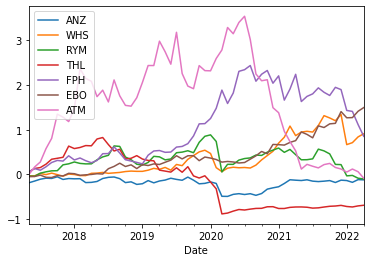

In [5]:
# Calculate monthly returns
monthly_ret = np.log(data).diff().dropna()
monthly_ret.add(1).cumprod().sub(1).plot()

In [6]:
# Variance Covariance Matrix
dfs = monthly_ret[stocks_list].cov()
dfs

,ANZ,WHS,RYM,THL,FPH,EBO,ATM
ANZ,0.005767,0.001620,0.002865,0.006760,-0.000662,0.001142,-0.000322
WHS,0.001620,0.004967,0.002850,0.003377,-0.000214,0.001309,-0.000900
RYM,0.002865,0.002850,0.007821,0.007102,0.001103,0.001154,0.002083
THL,0.006760,0.003377,0.007102,0.020454,-0.001560,0.001629,-0.001009
FPH,-0.000662,-0.000214,0.001103,-0.001560,0.006900,-0.001004,0.004366
EBO,0.001142,0.001309,0.001154,0.001629,-0.001004,0.002648,-0.002128
ATM,-0.000322,-0.000900,0.002083,-0.001009,0.004366,-0.002128,0.016017


In [7]:
monthly_ret.sample(5)

,ANZ,WHS,RYM,THL,FPH,EBO,ATM
Date,,,,,,,
2022-01-31,-0.009543,-0.287682,-0.205655,-0.081173,-0.160800,-0.057444,-0.060835
2020-09-30,-0.063384,0.056888,0.046520,0.069959,-0.102199,0.055523,-0.192160
2021-03-31,0.104078,0.136220,0.043413,0.105361,0.092976,0.036242,-0.117009
2021-06-30,0.018884,0.008683,0.001524,-0.023439,0.043678,-0.027483,0.094379
2019-05-31,0.024404,0.037477,-0.048050,-0.019498,-0.026275,0.040262,-0.059582


In [8]:
# Input: mean returns
dfr = monthly_ret[stocks_list].mean()#*12
dfr.name= 'Returns'
#dfr

In [9]:
sigma = pd.Series(np.diag(dfs)**.5, name = 'Sigma', index= stocks_list)
sigma = sigma.astype(float)
#sigma

<AxesSubplot:title={'center':'Returns and Sigmas for selection of NZ firms'}>

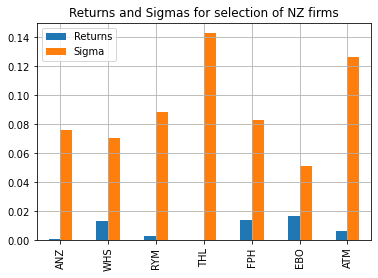

In [10]:
dfr.to_frame().join(sigma).plot(kind='bar',grid=True,table=False,legend=True, title = 'Returns and Sigmas for selection of NZ firms')

╒═════╤═══════════╕
│     │   Weights │
╞═════╪═══════════╡
│ ANZ │   -0.0842 │
├─────┼───────────┤
│ WHS │    0.1946 │
├─────┼───────────┤
│ RYM │   -0.2140 │
├─────┼───────────┤
│ THL │    0.0379 │
├─────┼───────────┤
│ FPH │    0.2509 │
├─────┼───────────┤
│ EBO │    0.7156 │
├─────┼───────────┤
│ ATM │    0.0991 │
╘═════╧═══════════╛


<AxesSubplot:title={'center':'Portfolio X Asset Allocation'}>

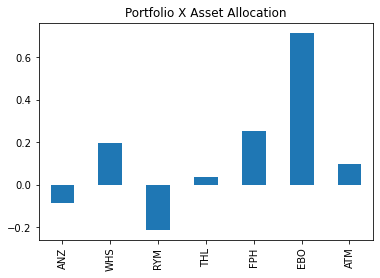

In [11]:
# Function: Calculate Envelope Portfolio proportions in one step
# see also https://www.youtube.com/watch?v=OGhGz8trZtw

def envelope_portfolio_df(dfs, dfr, constant):
    df_inv = pd.DataFrame(np.linalg.pinv(dfs.values), dfs.columns, dfs.columns)
    ex_ret = dfr - constant
    Z = df_inv @ ex_ret
    return Z/Z.sum() # Efficient Portfolio proportions

# Computing Portfolio X Asset Allocation

port_x_prop = envelope_portfolio_df(dfs, dfr, 0)
nice_print(pd.Series(port_x_prop), name= 'Weights')
port_x_prop.plot(kind='bar', title= 'Portfolio X Asset Allocation')

╒═════╤═══════════╕
│     │   Weights │
╞═════╪═══════════╡
│ ANZ │    0.2445 │
├─────┼───────────┤
│ WHS │    0.0932 │
├─────┼───────────┤
│ RYM │   -0.0086 │
├─────┼───────────┤
│ THL │   -0.0215 │
├─────┼───────────┤
│ FPH │    0.1804 │
├─────┼───────────┤
│ EBO │    0.4053 │
├─────┼───────────┤
│ ATM │    0.1067 │
╘═════╧═══════════╛


<AxesSubplot:title={'center':'Portfolio Y Asset Allocation'}>

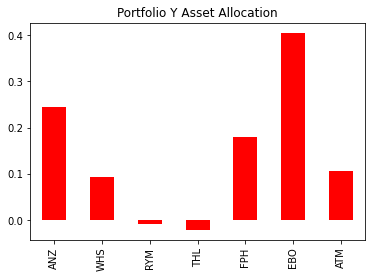

In [12]:
port_y_prop = envelope_portfolio_df(dfs, dfr, 0.04)
nice_print(pd.Series(port_y_prop), name= 'Weights')
port_y_prop.plot(kind='bar', color='r', title= 'Portfolio Y Asset Allocation')

In [13]:
# Input: Portfolio weights
#port_x_prop = pd.Series(np.array([0.2, 0.3, 0.3, 0.1, 0.1]), index=dfs.index, name= 'x_wei')
#print(pd.Series(port_x_prop))
#port_x_prop.plot(kind='bar')

In [14]:
#port_y_prop = pd.Series(np.array([0.1, 0.1, 0.1, 0.1, 0.6]), index=dfs.index, name= 'y_wei')
#print(pd.Series(port_y_prop))
#port_y_prop.plot(kind='bar', color='r')

In [15]:
# Portfolios Mean Returns

port_x_ret = dfr @ port_x_prop
port_y_ret = dfr @ port_y_prop

nice_print(pd.Series([port_x_ret, port_y_ret], index=['X','Y']), k=100, name = "Mean Returns")

╒════╤════════════════╕
│    │   Mean Returns │
╞════╪════════════════╡
│ X  │         1.7973 │
├────┼────────────────┤
│ Y  │         1.1393 │
╘════╧════════════════╛


In [16]:
# Portfolios Variance
port_x_var = port_x_prop @ dfs @ port_x_prop
port_y_var = port_y_prop @ dfs @ port_y_prop
nice_print(pd.Series([port_x_var,port_y_var],index=['X','Y']), name = "Portfolios Variance")

╒════╤═══════════════════════╕
│    │   Portfolios Variance │
╞════╪═══════════════════════╡
│ X  │                0.0015 │
├────┼───────────────────────┤
│ Y  │                0.0013 │
╘════╧═══════════════════════╛


In [17]:
# Covarinace(X,Y)
cov_xy = port_x_prop @ dfs @ port_y_prop
nice_print(pd.Series(cov_xy,index=["Cov(X,Y)"]))

╒══════════╤════════╕
│          │        │
╞══════════╪════════╡
│ Cov(X,Y) │ 0.0010 │
╘══════════╧════════╛


In [18]:
# Portfolios Standard Deviations
port_x_sigma = port_x_var**.5
port_y_sigma = port_y_var**.5

nice_print(pd.Series([port_x_sigma, port_y_sigma],index=['X','Y']), name = "Portfolios Sigma")

╒════╤════════════════════╕
│    │   Portfolios Sigma │
╞════╪════════════════════╡
│ X  │             0.0390 │
├────┼────────────────────┤
│ Y  │             0.0354 │
╘════╧════════════════════╛


In [19]:
# Correlation Coefficient (X,Y)
nice_print(pd.Series(cov_xy / (port_x_sigma * port_y_sigma),index=["Rho"]), name = "Correlation Coefficient")

╒═════╤═══════════════════════════╕
│     │   Correlation Coefficient │
╞═════╪═══════════════════════════╡
│ Rho │                    0.6986 │
╘═════╧═══════════════════════════╛


In [20]:
# Portfolio statistcis
dfp = pd.DataFrame([[port_x_ret, port_x_var, port_x_sigma],
                    [port_y_ret, port_y_var, port_y_sigma]],
             columns = ["Returns", "Variance", 'Sigma'],
             index = ['X', 'Y'])
nice_print(dfp.T)

╒══════════╤════════╤════════╕
│          │      X │      Y │
╞══════════╪════════╪════════╡
│ Returns  │ 0.0180 │ 0.0114 │
├──────────┼────────┼────────┤
│ Variance │ 0.0015 │ 0.0013 │
├──────────┼────────┼────────┤
│ Sigma    │ 0.0390 │ 0.0354 │
╘══════════╧════════╧════════╛


In [21]:
port_v_prop = envelope_portfolio_df(dfs, dfr, 0.025)
port_v_ret = dfr @ port_v_prop
port_v_var = port_v_prop @ dfs @ port_v_prop
port_v_sigma = port_v_var**.5

In [22]:
### Envelope Portfolios
# Portfolio Z is a portfolio constructed of portfolio X and portfolio Y.

Xa = 0.3
# port_z_weights = np.array([Xa, 1-Xa]).T
port_z_weights = pd.Series([Xa, 1-Xa],index=['X','Y'])

port_z_returns = pd.Series([port_x_ret, port_y_ret],index=['X','Y'])

# Portfolio X Returns
port_z_ret = port_z_weights @ port_z_returns

# Portfolio Variance
port_z_var =    port_z_weights.loc['X']**2 * port_x_var + port_z_weights.loc['Y']**2 * port_y_var + 2 * np.prod(port_z_weights) * cov_xy

# Portfolios Sigma
port_z_sigma = port_z_var**.5

In [23]:
nice_print(port_z_weights, name= 'Z_weights')
nice_print(port_z_returns, name= 'Z_returns')

print('\nport_z_ret:   {:2.4}'.format(port_z_ret))
print('\nport_z_var:   {:2.4}'.format(port_z_var))
print('\nport_z_sigma: {:2.4}'.format(port_z_sigma))

╒════╤═════════════╕
│    │   Z_weights │
╞════╪═════════════╡
│ X  │      0.3000 │
├────┼─────────────┤
│ Y  │      0.7000 │
╘════╧═════════════╛
╒════╤═════════════╕
│    │   Z_returns │
╞════╪═════════════╡
│ X  │      0.0180 │
├────┼─────────────┤
│ Y  │      0.0114 │
╘════╧═════════════╛

port_z_ret:   0.01337

port_z_var:   0.001154

port_z_sigma: 0.03396


<AxesSubplot:xlabel='Sigma'>

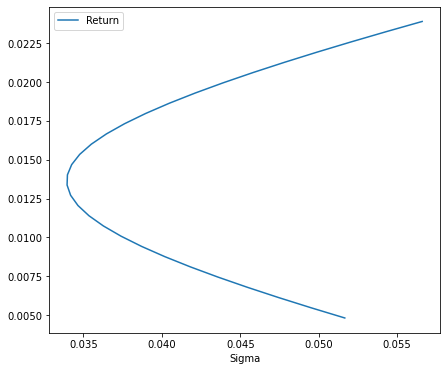

In [24]:
# Set an Array of Portfolio Weights
port_x_weight = np.arange(-1,2,0.1)
port_y_weight = 1-port_x_weight

# Portfolio Z Mean Returns
port_z_ret = port_x_weight * port_x_ret + port_y_weight * port_y_ret
#print(pd.Series(port_z_ret))

# Portfolios Sigma
port_z_sigma = (port_x_weight ** 2 * port_x_var + port_y_weight ** 2 * port_y_var + (port_x_weight * port_y_weight) * cov_xy * 2) ** 0.5
#print(pd.Series(port_z_sigma))

# Envelope
dfeff = pd.DataFrame({'Sigma': port_z_sigma, 'Return': port_z_ret}, columns=['Sigma', 'Return'])
dfeff.set_index('Sigma', inplace=True)
dfeff.plot(figsize=(7,6))

In [25]:
port_v_sigma

0.040983747935739036

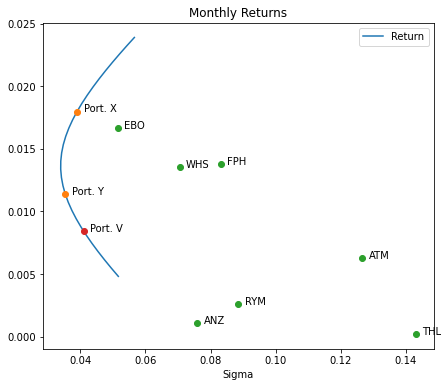

In [26]:
fig, ax = plt.subplots(figsize=(7,6))
ax.set_title(r'Monthly Returns')
dfeff.plot(ax=ax)
assets_sigma = np.diag(dfs)**0.5
ax.plot([port_x_sigma, port_y_sigma], [port_x_ret, port_y_ret], 'o') # portfolios
ax.plot(assets_sigma, dfr, 'o') # assets
# Labels
ax.text(port_x_sigma+0.002,port_x_ret,'Port. X')
ax.text(port_y_sigma+0.002,port_y_ret,'Port. Y')
ax.text(port_v_sigma+0.002,port_v_ret,'Port. V')
ax.plot(port_v_sigma, port_v_ret, 'o') # assets

for x in list(range(0,len(dfr))):
    ax.text(assets_sigma[x]+0.002,dfr.iloc[x],dfr.index[x])

### Computing the Global Minimum Variance Portfolio (GMVP)

In [27]:
# FUNCTION: GMVP as row
def GMVP_as_row(dfs):
    # take inverse of the var-cov-var matrix
    df_inv = pd.DataFrame(np.linalg.pinv(dfs.values), dfs.columns, dfs.columns)
    #return the sum of the rows divided by the total sum of the inversted matrix
    return df_inv.sum(axis=1).div(df_inv.sum().sum())

# GMVP Weights
GMVP_prop = GMVP_as_row(dfs)
print(pd.Series(GMVP_prop))

ANZ    0.132488
WHS    0.127723
RYM   -0.078611
THL   -0.001239
FPH    0.204436
EBO    0.511108
ATM    0.104096
dtype: float64


In [28]:
GMVP_prop

ANZ    0.132488
WHS    0.127723
RYM   -0.078611
THL   -0.001239
FPH    0.204436
EBO    0.511108
ATM    0.104096
dtype: float64

In [29]:
# GMVP Mean Return
GMVP_mean_ret = GMVP_prop @ dfr
print(pd.Series(GMVP_mean_ret,index=["GMVP Mean Return"]))

# GMVP Variance
GMVP_variance = GMVP_prop @ dfs @ GMVP_prop
print(pd.Series(GMVP_variance,index=["GMVP Variance"]))

# GMVP Sigma
GMVP_Sigma = GMVP_variance ** 0.5
print(pd.Series(GMVP_Sigma, index=["GMVP Sigma"]))

GMVP Mean Return    0.013636
dtype: float64
GMVP Variance    0.001152
dtype: float64
GMVP Sigma    0.033943
dtype: float64


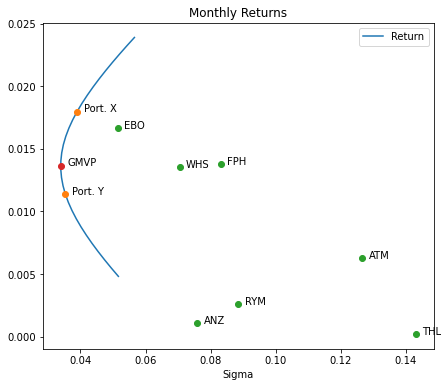

In [30]:
fig, ax = plt.subplots(figsize=(7,6))
ax.set_title(r'Monthly Returns')
dfeff.plot(ax=ax)
assets_sigma = np.diag(dfs)**0.5
ax.plot([port_x_sigma, port_y_sigma], [port_x_ret, port_y_ret], 'o') # portfolios
ax.plot(assets_sigma, dfr, 'o') # assets
ax.plot(GMVP_Sigma, GMVP_mean_ret, 'o') # assets
# Labels
ax.text(port_x_sigma+0.002,port_x_ret,'Port. X')
ax.text(port_y_sigma+0.002,port_y_ret,'Port. Y')
ax.text(GMVP_Sigma+0.002,GMVP_mean_ret,'GMVP')

for x in list(range(0,len(dfr))):
    ax.text(assets_sigma[x]+0.002,dfr.iloc[x],dfr.index[x])

### Efficient Portfolios Without Short Sales

In [31]:
from scipy.optimize import minimize
from qpsolvers import solve_qp

# Input: Variance Covariance Matrix
#dfsn = dfs.to_numpy()
#dfsn

In [32]:
# Input: mean returns
#dfrn = dfr.to_numpy()
#dfrn

In [33]:
#dfsn = np.array([[0.10,0.01,0.03,0.05], [0.01,0.30,0.06,-0.04],[0.03,0.06,0.40,0.02],[0.05,-0.04,0.02,0.50]])
#dfsn
#dfrn = np.array([0.02, 0.02, 0.08, 0.1])
#x = np.array([0.25,0.25,0.25,0.25])

In [34]:
# Input: constant
constant = 0.02

In [35]:
#dfr.index

In [36]:
#x = pd.Series(data = 1/len(dfr), index=list(np.arange(0,len(dfr)))) #dfr.index)
x = pd.Series(data = 1/len(dfr), index=dfr.index)
#x = np.full(shape=len(dfr),fill_value=1/len(dfr))
x

ANZ    0.142857
WHS    0.142857
RYM    0.142857
THL    0.142857
FPH    0.142857
EBO    0.142857
ATM    0.142857
dtype: float64

In [37]:
# Setting Target Function: Sharpe
def sharpe(x, dfr, constant, dfs):
    ex_ret = dfr - constant
    ret = ex_ret @ x
    var = x @ dfs @ x
    sigma = var ** 0.5
    sharpe = ret / sigma # set sharpe to minus sign for minimization
    return -sharpe

sharpe(x, dfr, constant, dfs)

0.24434420156022976

In [38]:
# No Short Constarints 
rnge = (0, math.inf)
bounds = tuple([rnge]*len(dfr))
bounds

((0, inf), (0, inf), (0, inf), (0, inf), (0, inf), (0, inf), (0, inf))

In [39]:
# Enforce sum of weights = 100%
def sum_weights_constr(x):
    return np.sum(x) - 1 # this should be equal to 0

sum_weight = {'type': 'eq', 'fun': sum_weights_constr, 'args': ()}
sum_weight

{'type': 'eq', 'fun': <function __main__.sum_weights_constr(x)>, 'args': ()}

In [40]:
sum_weights_constr(x)

-2.220446049250313e-16

In [41]:
# Stting initial guess
x0 = pd.Series(data = 1/len(dfr), index=list(np.arange(0,len(dfr)))) #dfr.index)
#x0 = np.full(shape=len(dfrn),fill_value=1/len(dfrn))
x0

0    0.142857
1    0.142857
2    0.142857
3    0.142857
4    0.142857
5    0.142857
6    0.142857
dtype: float64

In [42]:
dfs

,ANZ,WHS,RYM,THL,FPH,EBO,ATM
ANZ,0.005767,0.001620,0.002865,0.006760,-0.000662,0.001142,-0.000322
WHS,0.001620,0.004967,0.002850,0.003377,-0.000214,0.001309,-0.000900
RYM,0.002865,0.002850,0.007821,0.007102,0.001103,0.001154,0.002083
THL,0.006760,0.003377,0.007102,0.020454,-0.001560,0.001629,-0.001009
FPH,-0.000662,-0.000214,0.001103,-0.001560,0.006900,-0.001004,0.004366
EBO,0.001142,0.001309,0.001154,0.001629,-0.001004,0.002648,-0.002128
ATM,-0.000322,-0.000900,0.002083,-0.001009,0.004366,-0.002128,0.016017


In [43]:
dfr

ANZ    0.001088
WHS    0.013509
RYM    0.002581
THL    0.000211
FPH    0.013786
EBO    0.016630
ATM    0.006257
Name: Returns, dtype: float64

In [44]:
args = (dfr, constant , dfs)

result = minimize(sharpe, x0, args = args, method = 'SLSQP', bounds = bounds, constraints=sum_weight)

result.x

# Max Sharpe weights
print(pd.Series(data = result.x, index=dfr.index).round(5))

ANZ    0.0
WHS    0.0
RYM    0.0
THL    1.0
FPH    0.0
EBO    0.0
ATM    0.0
dtype: float64
